In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
%pip install prophet

In [ ]:
from prophet import Prophet

# Task 1, Section 1: Reading data and descriptive statistics

In [ ]:
df = pd.read_csv('Nat_Gas.csv')
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


In [ ]:
df['Dates'] = pd.to_datetime(df['Dates'])
df.head()

,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


In [ ]:
df.describe(include='all')

<ipython-input-130-174ba9bf1a5c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,Dates,Prices
count,48,48.000000
unique,48,NaN
top,2020-10-31 00:00:00,NaN
freq,1,NaN
first,2020-10-31 00:00:00,NaN
last,2024-09-30 00:00:00,NaN
mean,NaN,11.207083
std,NaN,0.757897
min,NaN,9.840000
25%,NaN,10.650000


# Section 2: Data Visualisation

In [ ]:
# Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary.
# This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for.
# Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future.

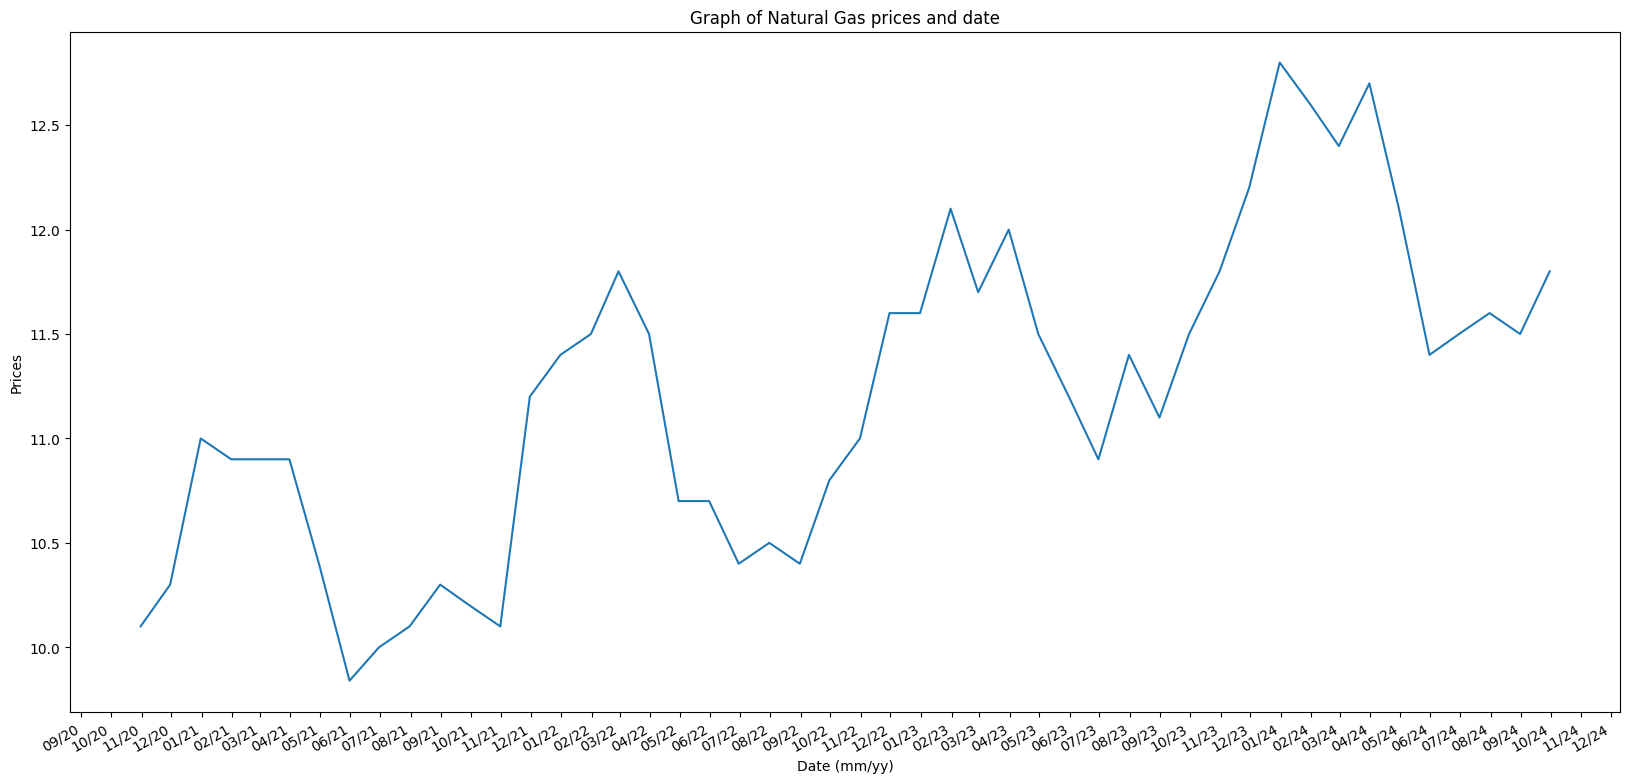

In [ ]:
# sizing the figure
fig, ax = plt.subplots(figsize=(20, 10))

# using mdates package to specify the number of months between each tick, and formatting the dates
month_locator = mdates.MonthLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%m/%y")

ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

# graph labels
plt.title('Graph of Natural Gas prices and date')
plt.xlabel('Date (mm/yy)')
plt.ylabel('Prices')

# plot graph
plt.plot(df['Dates'], df['Prices'])

# rotates and right aligns the x labels
fig.autofmt_xdate()

plt.show()

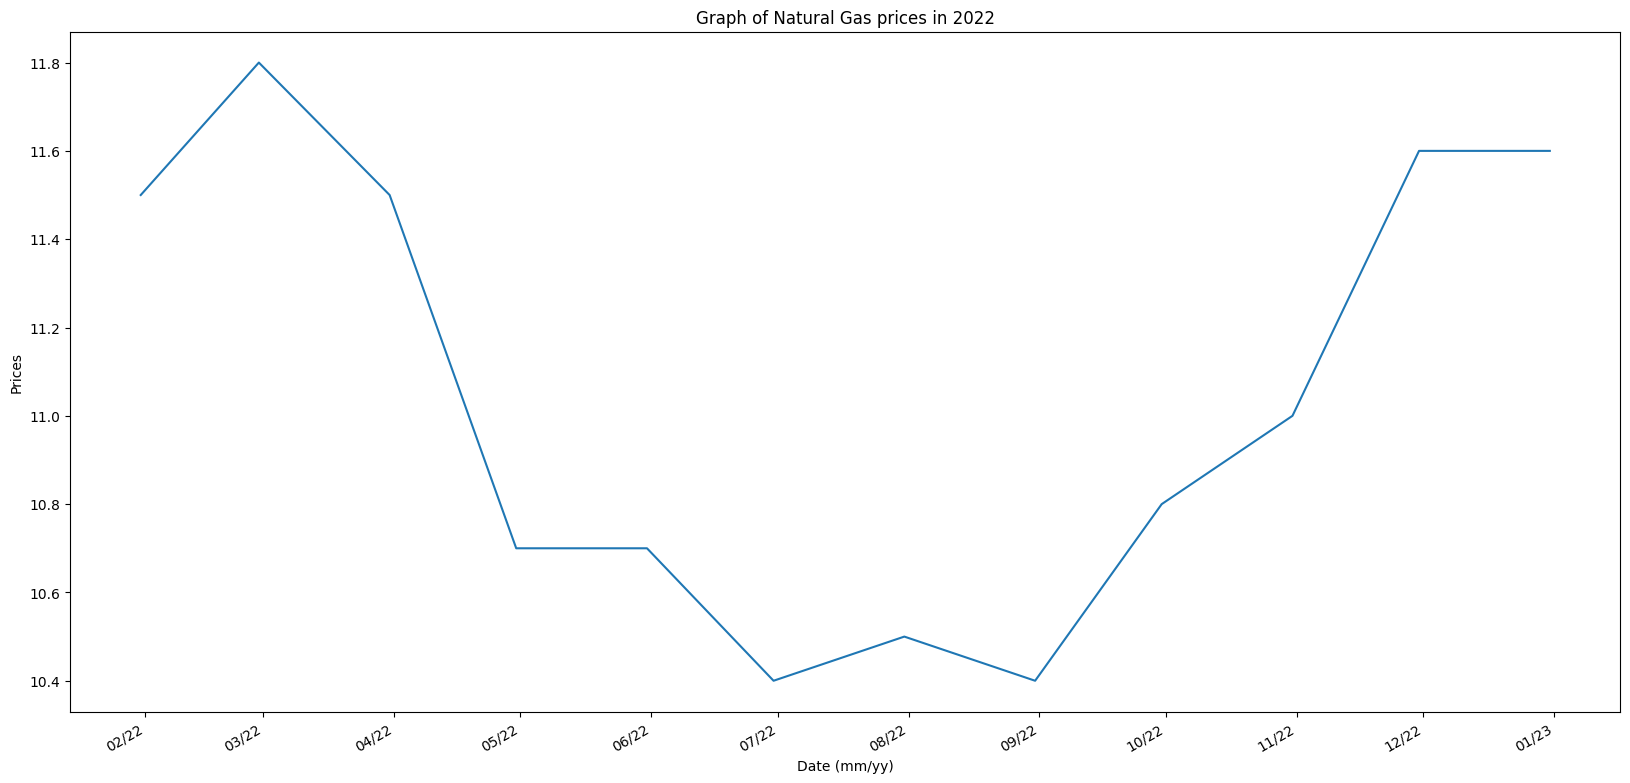

In [ ]:
# zooming in on a particular year, say 2022

# sizing the figure
fig, ax = plt.subplots(figsize=(20, 10))

# using mdates package to specify the number of months between each tick, and formatting the dates
month_locator = mdates.MonthLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%m/%y")

ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

# graph labels
plt.title('Graph of Natural Gas prices in 2022')
plt.xlabel('Date (mm/yy)')
plt.ylabel('Prices')

# getting only 2022 data
df_2022 = df[(df['Dates'] > '2021-12-31') & (df['Dates'] < '2023-01-01')]

# plot graph
plt.plot(df_2022['Dates'], df_2022['Prices'])

# rotates and right aligns the x labels
fig.autofmt_xdate()

plt.show()

Overview: Prices seem to always drop from April to September before picking back up from October to March

# Section 3: Rolling Statistics

Before doing time series forecasting, we need to ensure our data is stationary (i.e. both the rolling statistics remaing constant over time)

In [ ]:
# get the dates column so we can set the date as index later on
dates = df['Dates']

<ipython-input-135-bd2801e5e8a1>:19: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Dates'], dtype='object')
  rolmean = df.rolling(window=12).mean().set_index(dates)


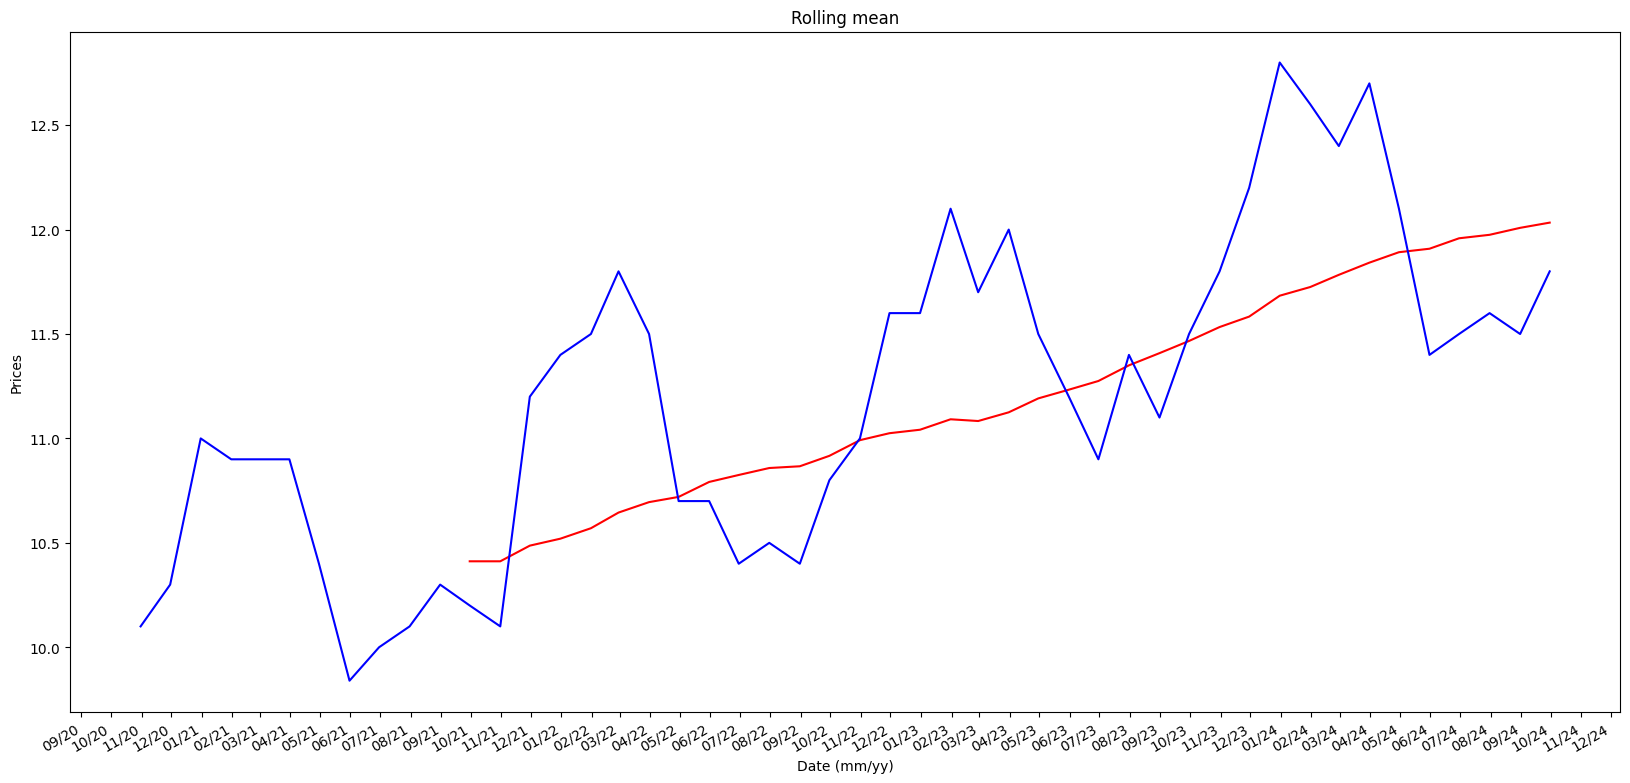

In [ ]:
# plot rolling statistics

# sizing the figure
fig, ax = plt.subplots(figsize=(20, 10))

# using mdates package to specify the number of months between each tick, and formatting the dates
month_locator = mdates.MonthLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%m/%y")

ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

# graph labels
plt.title('Rolling mean')
plt.xlabel('Date (mm/yy)')
plt.ylabel('Prices')

# rolling mean
rolmean = df.rolling(window=12).mean().set_index(dates)
plt.plot(rolmean.index, rolmean['Prices'], color='red', label='Rolling Mean')

# original data
plt.plot(df['Dates'], df['Prices'], color='blue', label='Original data')

# rotates and right aligns the x labels
fig.autofmt_xdate()

plt.show()

<ipython-input-136-eff4d36744bd>:18: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Dates'], dtype='object')
  rolstd = df.rolling(window=12).std().set_index(dates)


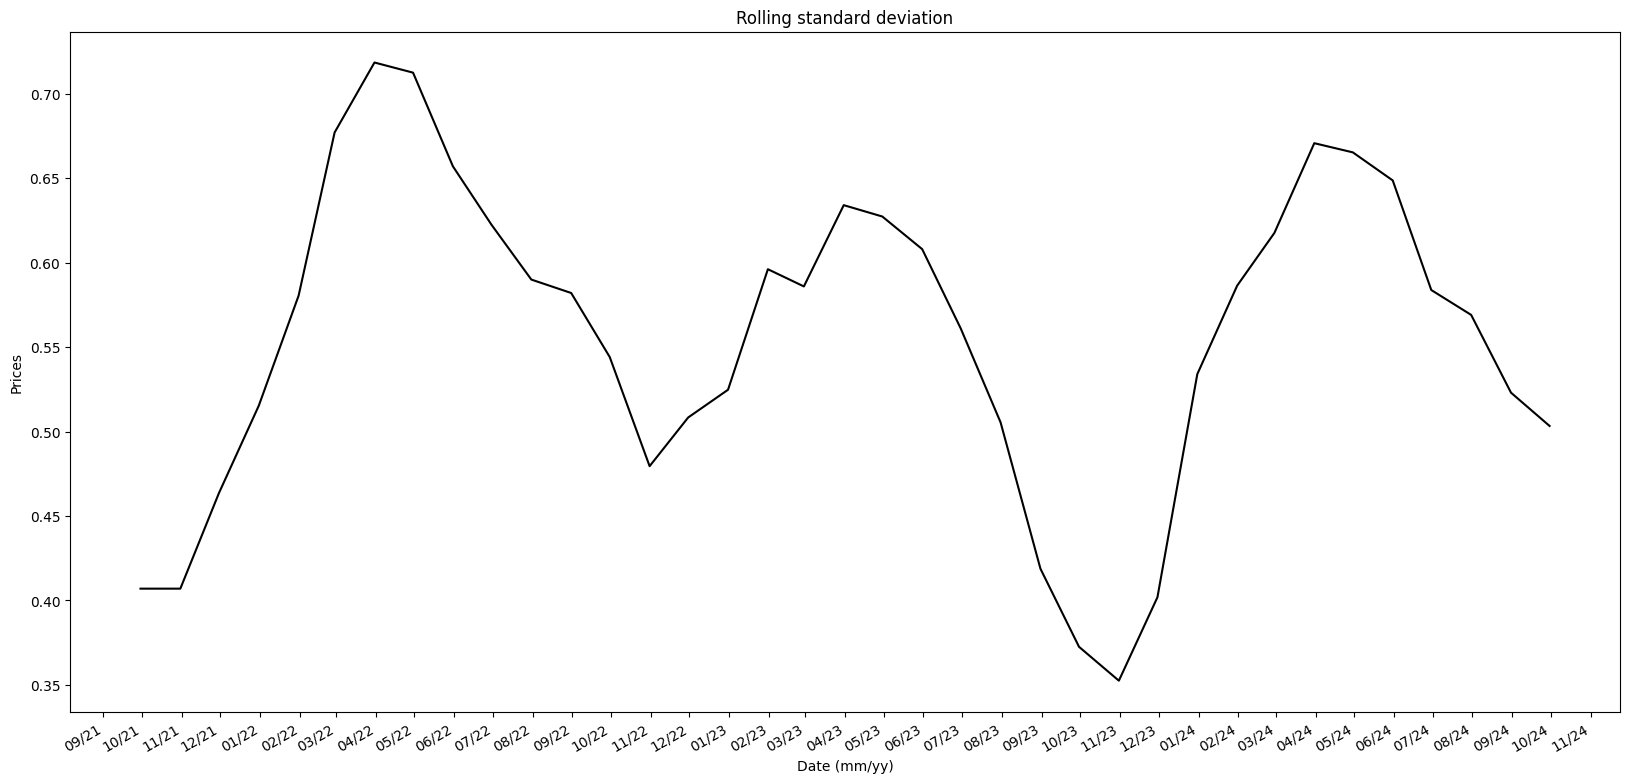

In [ ]:
# rolling standard deviation

# sizing the figure
fig, ax = plt.subplots(figsize=(20, 10))

# using mdates package to specify the number of months between each tick, and formatting the dates
month_locator = mdates.MonthLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%m/%y")

ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

# graph labels
plt.title('Rolling standard deviation')
plt.xlabel('Date (mm/yy)')
plt.ylabel('Prices')

rolstd = df.rolling(window=12).std().set_index(dates)
plt.plot(rolstd.index, rolstd['Prices'], color='black')

# rotates and right aligns the x labels
fig.autofmt_xdate()

plt.show()

Generally, prices are rising throughout the years. Standard deviation of prices seems to be roughly constant over the years.

To confirm this, let's try performing the Augmented Dickey-Fuller Test.

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# performing the Augmented Dickey-Fuller Test
dftest = adfuller(df['Prices'], autolag='AIC')

dfoutput = pd.Series(
    dftest[0:4],
    index=[
        'Test Statistic',
        'p-value',
        '#Lags Used',
        'Number of Observations Used',
    ],
)

for key, value in dftest[4].items():
  dfoutput["Critical Value (%s)" % key] = value

print('Results of adfuller test:')
print(dfoutput)

Results of adfuller test:
Test Statistic                  0.218077
p-value                         0.973257
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


The high p-value of 0.97325 tells us that our time series at the moment is not stationary.

Let's try to transform the data to achieve stationarity.

In [ ]:
dates = df['Dates']
dates.head()

0   2020-10-31
1   2020-11-30
2   2020-12-31
3   2021-01-31
4   2021-02-28
Name: Dates, dtype: datetime64[ns]

In [ ]:
# take natural logarithm of the prices
series_logscale = np.log(df['Prices'])
df_logscale = pd.DataFrame(series_logscale).set_index(dates)

In [ ]:
moving_average = df_logscale.rolling(window=12).mean()
moving_std = df_logscale.rolling(window=12).std()

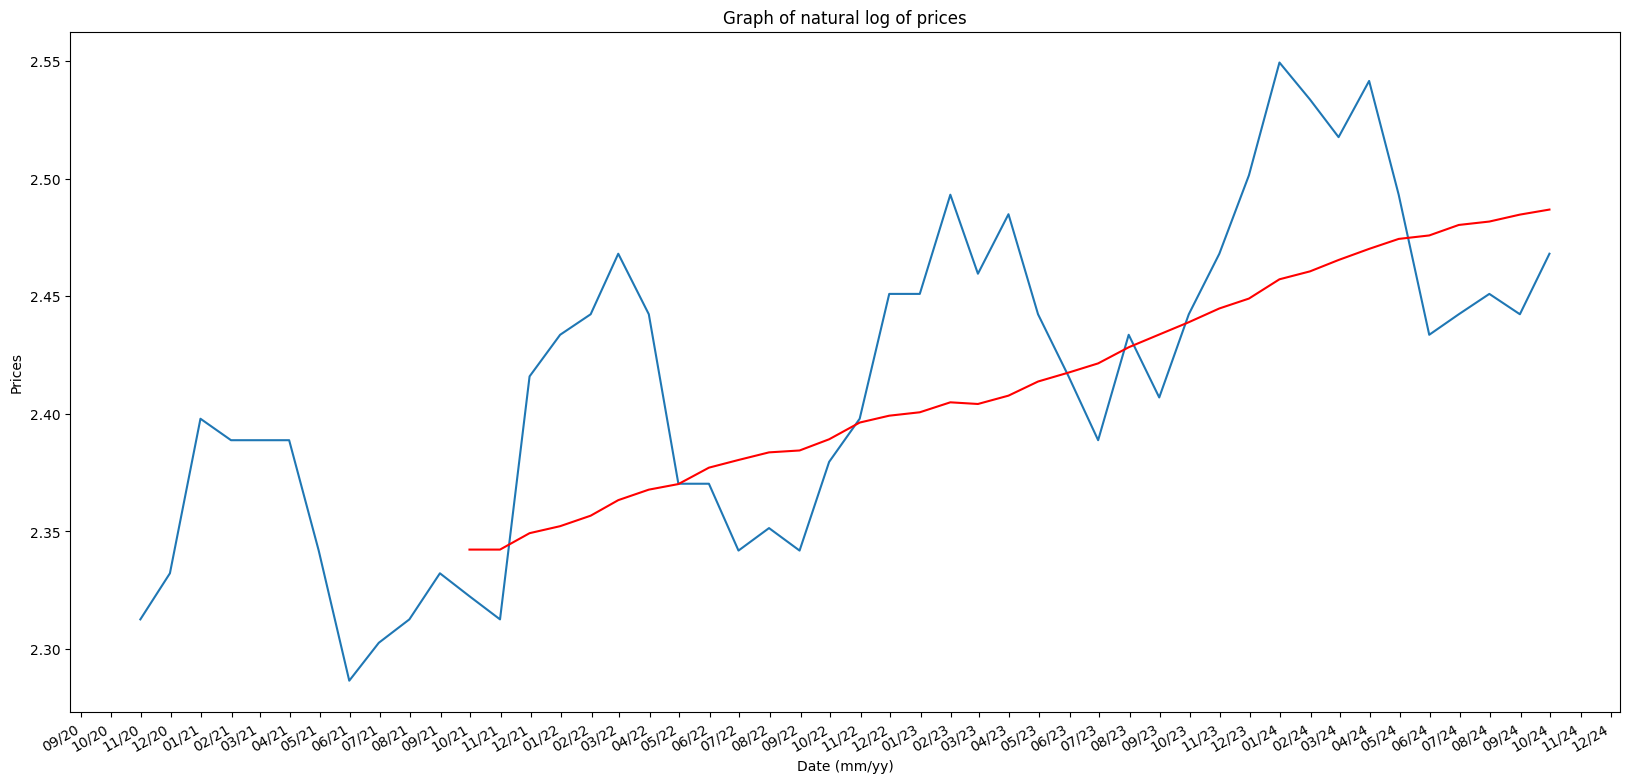

In [ ]:
# sizing the figure
fig, ax = plt.subplots(figsize=(20, 10))

# using mdates package to specify the number of months between each tick, and formatting the dates
month_locator = mdates.MonthLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%m/%y")

ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

# graph labels
plt.title('Graph of natural log of prices')
plt.xlabel('Date (mm/yy)')
plt.ylabel('Prices')

plt.plot(df_logscale, label='Natural log of prices')
plt.plot(moving_average, color='red', label='Moving Average')

# rotates and right aligns the x labels
fig.autofmt_xdate()

plt.show()

From the graph, we can see that even though rolling mean is not stationary, it is better than when no transformation was applied to the series.

Furthermore, both the time series with log scale and the moving average have a trend component. Thus subtraction of one from the other should remove the trend component of both.

```
logscale_L = stationary_part(L1) + trend(LT)
moving_avg_of_logscale_A = stationary_part(A1) + trend(AT)
resulting_series_R = L − A = (L1 + LT) − (A1 + AT) = (L1 − A1) + (LT − AT)
```

Trend of moving average and logscale series should have more or less the same trend, so LT - AT nearly equals to zero. R = L1 − A1.

In [ ]:
# subtract moving average from logscale
df_log_minus_ma = df_logscale - moving_average
df_log_minus_ma.head()

,Prices
Dates,
2020-10-31,NaN
2020-11-30,NaN
2020-12-31,NaN
2021-01-31,NaN
2021-02-28,NaN


In [ ]:
df_log_minus_ma.dropna(inplace=True)
df_log_minus_ma

,Prices
Dates,
2021-09-30,-0.019844
2021-10-31,-0.029696
2021-11-30,0.066702
2021-12-31,0.081425
2022-01-31,0.085693
2022-02-28,0.104834
2022-03-31,0.074616
2022-04-30,0.000143
2022-05-31,-0.006839


In [ ]:
def test_stationarity(timeseries):
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Prices'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

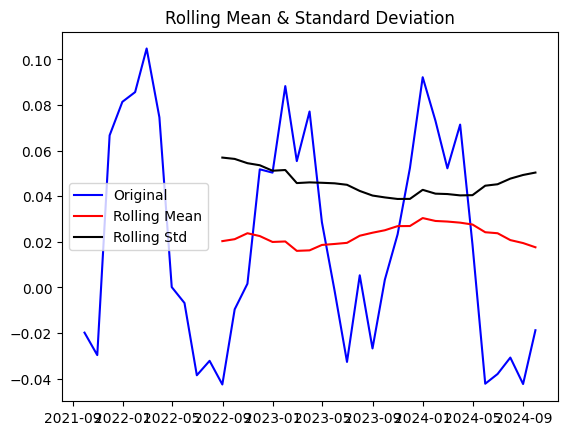

Results of Dickey Fuller Test:
Test Statistic                 -2.210411
p-value                         0.202488
#Lags Used                      7.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


In [ ]:
test_stationarity(df_log_minus_ma)

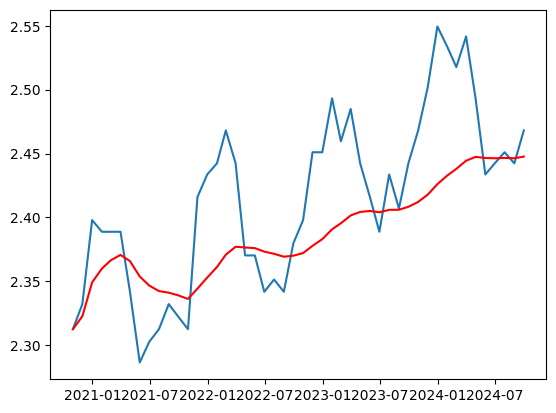

In [ ]:
# here we try the exponential decay transformation
df_exp_ma = df_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_logscale)
plt.plot(df_exp_ma, color='red')

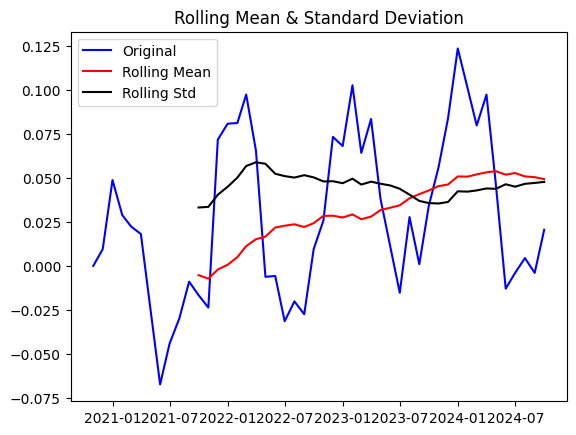

Results of Dickey Fuller Test:
Test Statistic                 -1.470706
p-value                         0.547950
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [ ]:
df_log_minus_exp = df_logscale - df_exp_ma
test_stationarity(df_log_minus_exp)

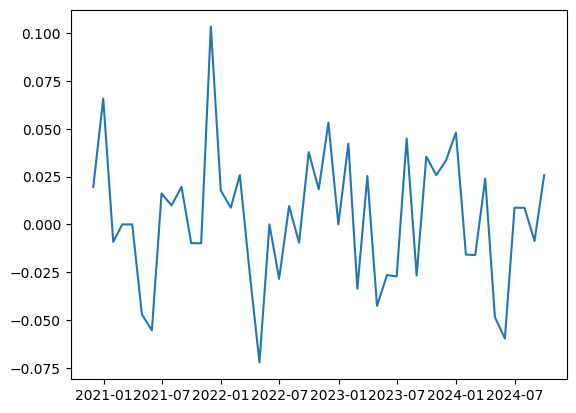

In [ ]:
# try the time shift transformation
df_shift = df_logscale - df_logscale.shift()
plt.plot(df_shift)

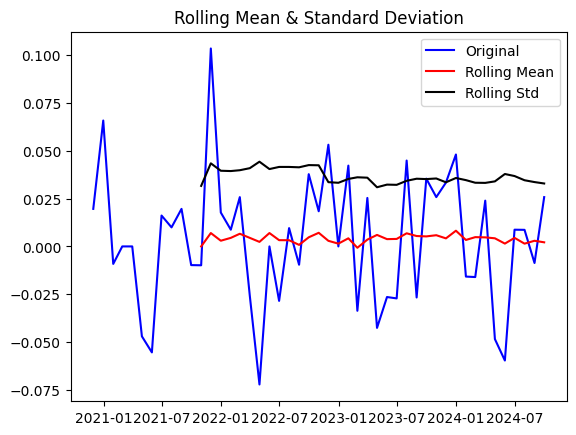

Results of Dickey Fuller Test:
Test Statistic                -6.922155e+00
p-value                        1.139189e-09
#Lags Used                     9.000000e+00
Number of Observations Used    3.700000e+01
Critical Value (1%)           -3.620918e+00
Critical Value (5%)           -2.943539e+00
Critical Value (10%)          -2.610400e+00
dtype: float64


In [ ]:
df_shift.dropna(inplace=True)
test_stationarity(df_shift)

Time shift transformation seems to work best for our time series data

# Section 4: Decompose time series into trend, seasonality and residuals

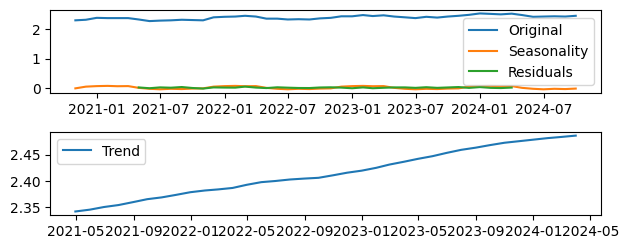

In [ ]:
decomposition = seasonal_decompose(df_logscale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_logscale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

Plotting ACF and PACF

In [ ]:
lag_acf = acf(df_shift, nlags=20)
lag_pacf = pacf(df_shift, nlags=20, method='ols')

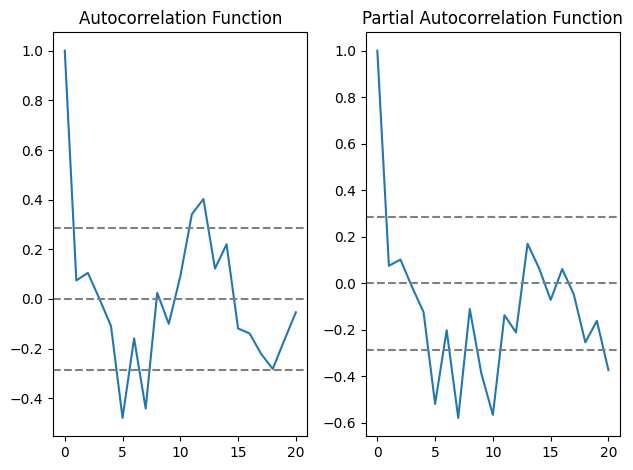

In [ ]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_shift)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_shift)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

From the ACF graph, we see that the curve touches y=0 between x=2 and x=5. Thus, we can try any value of Q from 2 to 5, and select the best fit.

From the PACF graph, we can see that the curve touches y=0 at x=4. Thus, P=4.

# Section 5: Building models and predicting natural gas prices

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS: 0.0713')

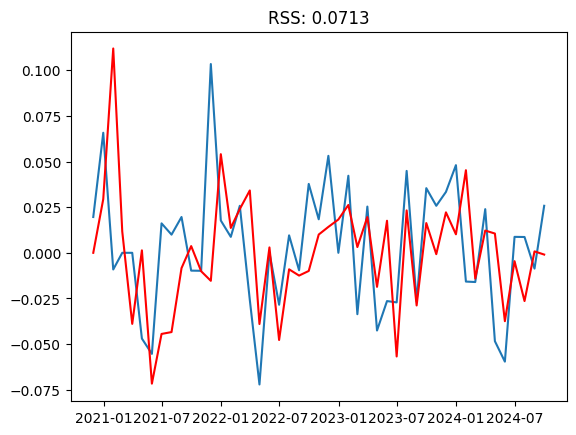

In [ ]:
model = ARIMA(df_shift, order=(4, 2, 4))
results_ar = model.fit()
plt.plot(df_shift)
plt.plot(results_ar.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ar.fittedvalues - df_shift['Prices'])**2))

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ar.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Dates
2020-11-30    0.000000
2020-12-31    0.029413
2021-01-31    0.111894
2021-02-28    0.011664
2021-03-31   -0.038910
dtype: float64


In [ ]:
# convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum

Dates
2020-11-30    0.000000
2020-12-31    0.029413
2021-01-31    0.141307
2021-02-28    0.152971
2021-03-31    0.114061
2021-04-30    0.115407
2021-05-31    0.043767
2021-06-30   -0.000658
2021-07-31   -0.044066
2021-08-31   -0.052462
2021-09-30   -0.048784
2021-10-31   -0.058888
2021-11-30   -0.074223
2021-12-31   -0.020215
2022-01-31   -0.006598
2022-02-28    0.017384
2022-03-31    0.051530
2022-04-30    0.012525
2022-05-31    0.015474
2022-06-30   -0.032266
2022-07-31   -0.041309
2022-08-31   -0.053777
2022-09-30   -0.063715
2022-10-31   -0.053718
2022-11-30   -0.039525
2022-12-31   -0.021282
2023-01-31    0.004911
2023-02-28    0.008063
2023-03-31    0.027638
2023-04-30    0.009005
2023-05-31    0.026562
2023-06-30   -0.030211
2023-07-31   -0.006992
2023-08-31   -0.035823
2023-09-30   -0.019533
2023-10-31   -0.020277
2023-11-30    0.001879
2023-12-31    0.012014
2024-01-31    0.057250
2024-02-29    0.043148
2024-03-31    0.055336
2024-04-30    0.065886
2024-05-31    0.028442
2024-

In [170]:
predictions_ARIMA_log = pd.Series(df_logscale['Prices'].iloc[0], index=df_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum.shift(periods=-1), fill_value=0)
predictions_ARIMA_log.head()

Dates
2020-10-31    2.312535
2020-11-30    2.341948
2020-12-31    2.453842
2021-01-31    2.465506
2021-02-28    2.426597
dtype: float64

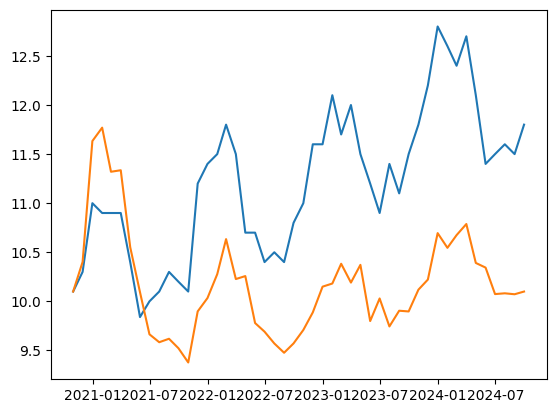

In [171]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df['Dates'], df['Prices'])
plt.plot(predictions_ARIMA)

# Section 6: Predicting future values using Prophet

For this section, I will be using the Prophet module to predict natural gas

*   For this section, I will be using the Prophet module to predict natural gas prices for the next 12 months
*   Prophet does decomposition based on rate of change
*   Since the data shows seasonality (from April to September, prices drop) and a general increasing trend


[Time Series Forecasting Methods](https://www.influxdata.com/time-series-forecasting-methods/#:~:text=Time%20series%20forecasting%20is%20a,Astronomy)



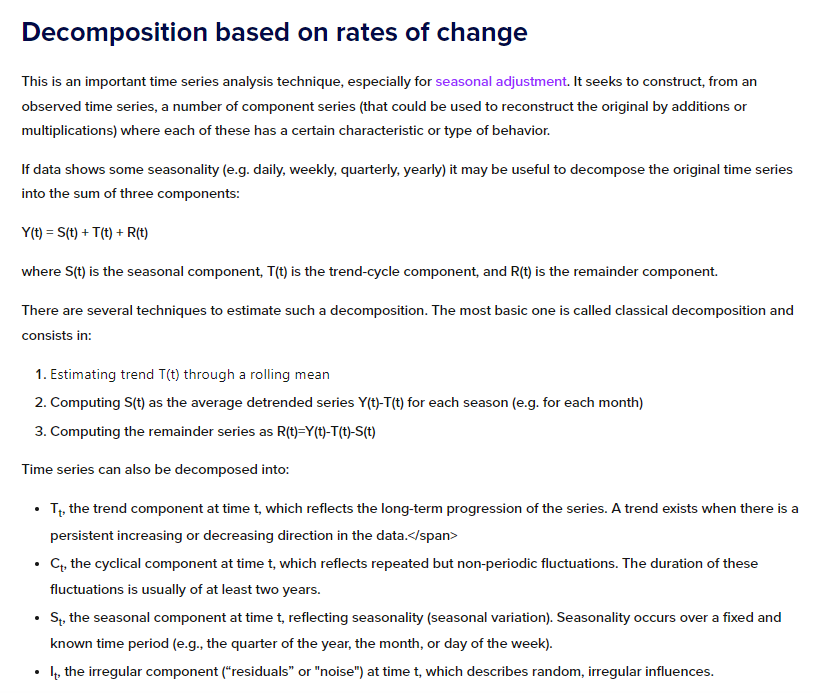

In [ ]:
mapper = {
    'Dates': 'ds',
    'Prices': 'y'
}

# rename columns to 'ds' and 'y' as per Prophet documentation
df.rename(columns=mapper, inplace=True)
df.head()

,ds,y
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


In [ ]:
# creating model and fitting
model = Prophet()
model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6383zs4g/z72ay6uh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6383zs4g/gnd_lfpi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10263', 'data', 'file=/tmp/tmp6383zs4g/z72ay6uh.json', 'init=/tmp/tmp6383zs4g/gnd_lfpi.json', 'output', 'file=/tmp/tmp6383zs4g/prophet_modelk3r2kpd5/prophet_model-20231214082200.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# use prophet to generate a dataframe of all the months + next 12 months
future = model.make_future_dataframe(periods=12, freq='m')
future.tail()

,ds
55,2025-05-31
56,2025-06-30
57,2025-07-31
58,2025-08-31
59,2025-09-30


In [ ]:
# predict using the prophet model
# yhat are the values that the model predicts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(n=12)

,ds,yhat,yhat_lower,yhat_upper
48,2024-10-31,11.960253,11.785322,12.141249
49,2024-11-30,12.497219,12.308733,12.673244
50,2024-12-31,12.915386,12.742999,13.102186
51,2025-01-31,12.939215,12.767086,13.113472
52,2025-02-28,12.875285,12.690568,13.046374
53,2025-03-31,12.951613,12.754653,13.125994
54,2025-04-30,12.339307,12.165443,12.523982
55,2025-05-31,11.853798,11.680110,12.036699
56,2025-06-30,11.848575,11.673397,12.041141
57,2025-07-31,11.983327,11.803393,12.169812


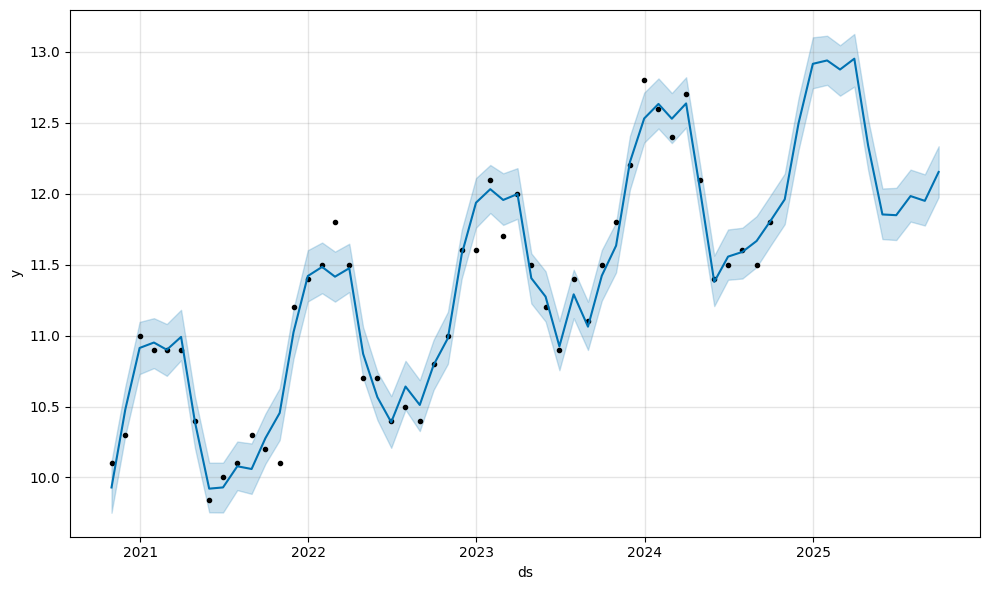

In [ ]:
# using Prophet to plot a forecast of the trends after the given data, to extrapolate
fig1 = model.plot(forecast)

In [ ]:
forecast = forecast[['ds', 'yhat']]

forecast.set_index('ds', inplace=True)
forecast.head()

,yhat
ds,
2020-10-31,9.929508
2020-11-30,10.480367
2020-12-31,10.912891
2021-01-31,10.951077
2021-02-28,10.900114


In [ ]:
# convert forecast values from monthly to daily, and interpolating the data
forecast = forecast.resample('D').interpolate()

In [ ]:
forecast.head()

,yhat
ds,
2020-10-31,9.929508
2020-11-01,9.947870
2020-11-02,9.966232
2020-11-03,9.984594
2020-11-04,10.002956


In [ ]:
def price_forecast(date):
  # search the date from forecast dataframe, then return the interpolated predicted price
  return forecast.loc[date]['yhat']

In [ ]:
price_forecast('2020-11-01')

9.947870014109252

# Task 2

*   write a function that is able to use the data I created previously to price the contract
*   client may want to choose multiple dates to inject and withdraw a set amount of gas, so your approach should generalize the explanation from before
*   Consider all the cash flows involved in the product





In [ ]:
# Injection dates.
# Withdrawal dates.
# The prices at which the commodity can be purchased/sold on those dates.
# The rate at which the gas can be injected/withdrawn.
# The maximum volume that can be stored.
# Storage costs.
# Write a function that takes these inputs and gives back the value of the contract

In [ ]:
from collections import Counter

class Pricing:
  def __init__(self, purchases, withdrawals, storage_cost, prices=forecast, max_vol=10000, current_capacity=0):
    # purchases and withdrawals should be dictionaries, with the key as the date of purchase/withdrawal and value as the amount of natural gas bought/sold
    self.purchases = purchases
    self.withdrawals = withdrawals

    # current_capacity, max_vol and storage_cost are numeric values
    self.max_vol = max_vol
    self.current_capacity = current_capacity
    # storage cost should be a rate on a per day basis
    self.storage_cost = storage_cost

    self.profit = 0

    # prices is the pandas dataframe of all the predicted prices earlier
    self.prices = prices

  def check_vol(self):
    if self.current_capacity >= self.max_vol:
      raise Exception(f'Current capapcity exceeds the maximum storage volume. Current capacity is {self.current_capacity}.')
    else:
      pass

  def calculate_money(self):
    # get the merged dictionary of amount bought or sold on certain days
    merged_dict = self.merge_dicts()

    # calculate the amount of money earned from only purchasing and withdrawing the money on the merged dictionary
    # if the value of the corresponding key is negative, it means it was a withdrawal, and the amount withdrawn will be negative
    for key, value in merged_dict.items():
      price = self.prices.loc[key]['yhat']
      if value < 0:
        # multiply by -1 to make the withdrawal revenue positive
        revenue = value * price * (-1)
        self.profit += revenue
      elif value > 0:
        # multiply by -1 to make purchase cost negative
        cost = value * price * (-1)
        self.profit += cost
      else:
        # if we have a net zero on a date (in the merged dictionary, quantity bought and quantity sold equal each other and cancel out to be zero)
        continue

    # find the length of time the natural gas has been stored by getting the first and last value of the merged_dict keys
    dates_list = list(merged_dict.keys())
    start_date = pd.to_datetime(dates_list[0])
    end_date = pd.to_datetime(dates_list[-1])
    # calculate length of time natural gas has been stored, a timedelta object
    length_days = (end_date - start_date).days

    self.profit = self.profit - self.storage_cost * length_days
    return self.profit

  def sort_dates(self, dictionary):
    # takes in a dictionary, then sorts out the dates chronologically
    sorted_list = sorted(dictionary.items())

    sorted_dict = {}
    for key, value in sorted_list:
      sorted_dict[key] = value

    return sorted_dict

  def merge_dicts(self):
    # convert the dictionaries into Counter objects to add them together, then convert it back into a dictionary
    # create 2 dummy variables to store counter objects so as to not alter the original
    dummy1 = Counter(self.purchases)
    dummy2 = Counter(self.withdrawals)

    # subtract values from the counters, then convert them back to dictionaries
    dummy1.subtract(dummy2)
    merged_dict = dict(dummy1)

    # call sort_dates method on merged dict to get
    merged_dict = self.sort_dates(merged_dict)

    # loop through the merged dictionary to see if there is any point in time when capacity exceeds maximum volume for storage
    for key, value in merged_dict.items():
      self.current_capacity += value
      self.check_vol()

    return merged_dict

In [ ]:
purchases = {
    '2022-09-10	': 100,
    '2020-12-21': 100,
}

withdrawals = {
    '2025-03-08': 200,
}

price = Pricing(purchases, withdrawals, storage_cost=0.1)
price.calculate_money()

287.3596926289676